# TF-IDF Vs Word2Vec Vs Fasttext

En esta notebook vamos a analizar las reviews hechas por distintos usuarios de Kindley de los libros que leyeron. 
Cada review consta de varios datos, datos del reviwer, codigo del libro, fecha, que puntaje le puso el reviewer al libro, donde 1 indica puntaje negativo, 2 neutral y 3 positivo y dos campos de texto: summary y ReviewText. Para simplificación de este ejercicio creamos el campo wholereview que es la concatenación de ambos.

### El objetivo será intentar predecir si una review fue positiva, neutra o negativa en base al texto del review.

Para esto probaremos como funciona un clasificador RandomForest utilizando distintos embeddings: TF-IDF, Word2Vec y Fasttext

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv

from sklearn.model_selection import RandomizedSearchCV
from  sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from  sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
import nltk
from gensim.models.doc2vec import Doc2Vec

In [3]:
df = pd.read_csv('../datasets/kindley_reviews.csv') 

Comencemos por ver un poco los datos

In [22]:
df.head()

,Unnamed: 0,Unnamed: 0.1,reviewerID,asin,reviewerName,helpful1,helpful2,reviewText,overall,summary,unixReviewTime,reviewTime,length,length_summary,review,wholereview,lang
0,302293,302294,A23LX12CA3G4FG,B0099RFUDC,"Jeni ""Jeni""",2,3,just a very basic guide to take proper photogr...,4,cute,1.357517e+09,"01 7, 2013",100,4,3,cute. just a very basic guide to take proper p...,en
1,827176,827177,A1D0ZVQMEINPSR,B00IEI3X72,Ana A.,1,1,this book capture my attention because as a ch...,5,autism,1.395187e+09,"03 19, 2014",554,6,3,autism. this book capture my attention because...,en
2,919758,919759,A3PTB483RGL0LJ,B00K4EGDSU,Myla M.,0,0,monty and risas relationship starts in las veg...,4,reluctant readerat first,1.399507e+09,"05 8, 2014",538,28,3,reluctant readerat first. monty and risas rela...,en
3,311029,311030,AE5U8BWEJSHOH,B009G9LJKG,Amazon Customer,0,0,this was extremely similar to the authors othe...,4,i enjoy this authors upbeat romances,1.360022e+09,"02 5, 2013",533,36,3,i enjoy this authors upbeat romances. this was...,en
4,65106,65107,A18N2582WGL8UC,B004XJ4KAK,Karen Grubel,1,1,very good book i liked jessie mark and jim ker...,4,super,1.370995e+09,"06 12, 2013",172,5,3,super. very good book i liked jessie mark and ...,en


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154094 entries, 0 to 154093
Data columns (total 17 columns):
Unnamed: 0        154094 non-null int64
Unnamed: 0.1      154094 non-null int64
reviewerID        154094 non-null object
asin              154094 non-null object
reviewerName      154092 non-null object
helpful1          154094 non-null int64
helpful2          154094 non-null int64
reviewText        154093 non-null object
overall           154094 non-null int64
summary           153888 non-null object
unixReviewTime    154094 non-null float64
reviewTime        154094 non-null object
length            154094 non-null int64
length_summary    154094 non-null int64
review            154094 non-null int64
wholereview       154094 non-null object
lang              154094 non-null object
dtypes: float64(1), int64(8), object(8)
memory usage: 20.0+ MB


Para simplificación del ejercicio hicimos un pre balanceo de clases, mediante un subsampling equiparamos la cantidad de instancias por cada puntuación

In [25]:
df['review'].value_counts()

2    51387
1    51356
3    51351
Name: review, dtype: int64

Como el objetivo será ver con que embeddings nuestro modelo puede clasificar mejor, antes de realizar las transformaciones separaremos datos para evaluación

In [4]:

X_dev, X_eval, y_dev, y_eval = train_test_split(df, df['review'], test_size=0.1, random_state=42) 

### TF-IDF

Comenzaremos con TF-IDF, para eso utilizaremos la libreria TfidfVectorizer, como la mayoría de nuestras reviews están en ingles utilizaremos el hiper-parametro stop_words para remover este tipo de palabras

In [110]:

vectorizer = TfidfVectorizer(stop_words='english')

vectorizer.fit( list(X_dev['wholereview'].values))
train_vectorized = vectorizer.transform(X_dev['wholereview'])


Un primer enfoque que utilizaremos para intentar estimar la "calidad" de nuestro embeddings será visualizarlos mediante una reducción dimensional (t-SNE) y colorealos en base al score, es decir si el embedding es una representación de una review, positiva, neutra o negativa. 

La idea es que si nuestros embeddings son buenas representaciones los embeddings de cada tipo de review tenderán a conformar cluster distintos. 

In [ ]:

fmd = train_vectorized
svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
svd.fit(fmd.T)
X_embedded = TSNE(n_components=2).fit_transform(svd.components_.T)

Grafiquemo ahora nuestro embeddings reducidos mediante un scatter plot

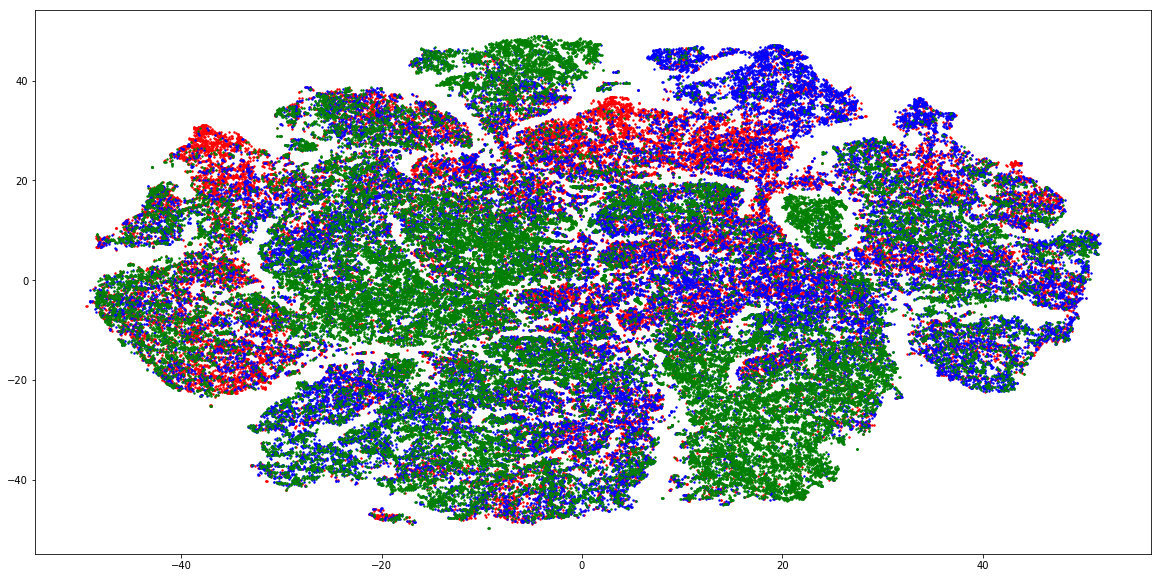

In [33]:

fig1 = plt.figure(figsize=(20,10),facecolor='white')
ax = fig1.add_subplot(1, 1, 1) 
ax.set_facecolor('white')
plt.scatter(X_embedded[X_dev['review']==1,0], X_embedded[X_dev['review']==1,1], color='r', s=2)
plt.scatter(X_embedded[X_dev['review']==2,0], X_embedded[X_dev['review']==2,1], color='b', s=2)
plt.scatter(X_embedded[X_dev['review']==3,0], X_embedded[X_dev['review']==3,1], color='g', s=2)
plt.show()

Podemos observar que los embeddings verdes (positivos) se diferencian bastante bien del resto, sin embargo los rojos y azules estan muy mezclados. Esto seguramente produzca que nuestro clasificador no pueda haber buenas inferencias.

Veamoslo mediante nuestro RandomForest

In [111]:
X_train, X_test, y_train, y_test = train_test_split(train_vectorized,X_dev['review'], test_size=0.2, random_state=0)

Para estimar los mejores hiper-parámetros utilizaremos RandomGridSearch

In [112]:
tuned_parameters =  {'max_depth': sp_randint(2, 20),"max_features": sp_randint(2, 34),"n_estimators":sp_randint(5, 20)}


clfdt = RandomizedSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='f1_macro',n_jobs=5)
clfdt.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [113]:
randomForest = RandomForestClassifier(max_depth=clfdt.best_params_['max_depth'],max_features=clfdt.best_params_['max_features'],n_estimators=clfdt.best_params_['n_estimators'])
randomforest =  cross_val_score(randomForest, X_train, y_train, cv=5, scoring='f1_macro',n_jobs=5)

In [114]:
print("Random Forest F1_score: %0.2f (+/- %0.2f)" % (randomforest.mean(), randomforest.std() * 2))

Random Forest F1_score: 0.33 (+/- 0.08)


La metrica utilizada es f1_macro, que en sklearn lo que nos da es el promedio f1_score para cada clase. Podemos ver que el score es bastante malo, veamos que sucede al estimar los embeddings mediante word2vec

### Word2Vec

Veamos ahora si mediante Word2Vec podemos mejorar nuestros embeddings y predicciones. Para eso utilizaremos la librería Doc2Vec (esta librería implementa word2Vec). Crearemos nuestros embeddings de 200 dimensiones (200 neuoronas en la capa oculta), ademas eliminaremos palabras con menos de 4 apariciones y entrenaremos la red con 40 epochs.

In [5]:


model = Doc2Vec(vector_size=200, min_count=4, epochs=40)


Para transformar nuestra matriz de reviews en el formato necesario para ser procesado por doc2vec definimos la siguiente funcion

In [6]:
import gensim
def read_corpus(docs):    
        for  i, line in enumerate(docs):
            tokens = gensim.utils.simple_preprocess(line)
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            

Ahora si creamos nuestro corpus de entrenamiento

In [8]:

train_corpus = list(read_corpus(list(X_dev['wholereview'].values)))

Creamos el vocabulario (1-hot-encoding)

In [9]:
model.build_vocab(train_corpus)

Entrenamos neustro modelo

In [10]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

ahora vuelvo a convertir en matriz a nuestros embeddings

In [11]:
vectors = []
for i in range(0,len(model.docvecs)):
    vectors.append(model.docvecs[i])

In [13]:
X_embedded = np.reshape(vectors, (len(vectors), 200))

Al igual que para TF-IDF reduciremos los embeddings estimados mediante t-SNE para tener una primera idea de la calidad de estas representaciones

In [16]:


svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
svd.fit(X_embedded.T)
X_embedded = TSNE(n_components=2).fit_transform(svd.components_.T)

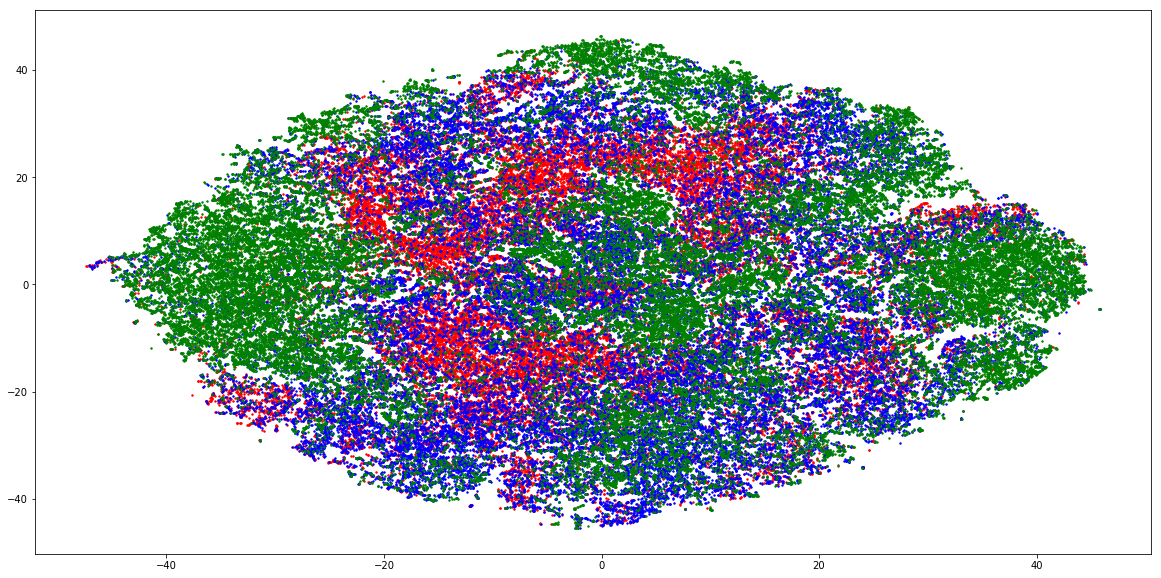

In [17]:
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(20,10),facecolor='white')
ax = fig1.add_subplot(1, 1, 1) 
ax.set_facecolor('white')
plt.scatter(X_embedded[X_dev['review']==1,0], X_embedded[X_dev['review']==1,1], color='r', s=2)
plt.scatter(X_embedded[X_dev['review']==2,0], X_embedded[X_dev['review']==2,1], color='b', s=2)
plt.scatter(X_embedded[X_dev['review']==3,0], X_embedded[X_dev['review']==3,1], color='g', s=2)
plt.show()

Si bien no cambio demasiado, pareciera que los azules y rojos estan un poco mejor separados, constatemoslo con neustro RandomForest

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_embedded,X_dev['review'], test_size=0.2, random_state=0)

In [20]:
tuned_parameters =  {'max_depth': sp_randint(2, 20),"max_features": sp_randint(2, 34),"n_estimators":sp_randint(5, 20)}


clfdt = RandomizedSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='f1_macro',n_jobs=5)
clfdt.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [21]:
randomForest = RandomForestClassifier(max_depth=clfdt.best_params_['max_depth'],max_features=clfdt.best_params_['max_features'],n_estimators=clfdt.best_params_['n_estimators'])
randomforest =  cross_val_score(randomForest, X_train, y_train, cv=5, scoring='f1_macro',n_jobs=5)

In [22]:
print("Random Forest F1_score: %0.2f (+/- %0.2f)" % (randomforest.mean(), randomforest.std() * 2))

Random Forest F1_score: 0.54 (+/- 0.01)


Podemos ver que F1 score mejoró bastante, sin embargo sigue sin ser muy bueno. Veamos ahora que sucede con nuestro último enfoque, Fasttext

### Fasttext

Fasttext lo correremos mediante terminal, por lo tanto necesitamos crear nuestros archivo de entrenamiento. Al mismo lo llamaremos train_dataset.txt, cada fila comenzara con el tag \_\_label\_\_\[review\] donde review es el score (1,2 o 3), se comienza así porque es el formato solicitado por fasttext para saber a que clase pertenece cada input. Luego de este tag concatenaremos el texto del wholereview

In [83]:
text_file = open("train_dataset.txt", "w")
for index, row in X_dev.iterrows():    
    text_file.write("__label__"+str(row['review']) +" ,  "+ row['wholereview'] + "\n")
    pass

Para el entrenamiento utilizaremos los [pretrained vector en ingles de wikipedia](https://fasttext.cc/docs/en/pretrained-vectors.html). La dimensión estimada será de 300 porque es la dimensión en la que están estos vectores. 

Para esto correremos la siguiente orden por termianl

```bash
./fasttext supervised -input train_dataset.txt -output fasttext -pretrainedVectors wiki-news-300d-1M.vec -dim 300 -wordNgrams 2
```

Ahora creamos 3 set de datos (uno de cada clase) para calcular sus embeddings

In [ ]:
df_under_pos = X_dev[X_dev['review']==3]
text_file = open("pos_dataset.txt", "w")
for index, row in df_under_pos.iterrows():    
    text_file.write(row['wholereview'] + "\n")
    pass
df_under_pos = X_dev[X_dev['review']==2]
text_file = open("neutral_dataset.txt", "w")
for index, row in df_under_pos.iterrows():    
    text_file.write(row['wholereview'] + "\n")
    pass
df_under_pos = X_dev[X_dev['review']==1]
text_file = open("neg_dataset.txt", "w")
for index, row in df_under_pos.iterrows():    
    text_file.write( row['wholereview'] + "\n")
    pass

Ahora corremos lo sigueinte por terminal para imprimir los embeddings
```bash
./fasttext print-sentence-vectors fasttext.bin < pos_dataset.txt > pos_dataset-vec.csv
./fasttext print-sentence-vectors fasttext.bin < neutral_dataset.txt > neutral_dataset-vec.csv
./fasttext print-sentence-vectors fasttext.bin < neg_dataset.txt > neg_dataset-vec.csv
```
Luego, levantamos los embeddings estimados por fasttext, para esto usamos la siguiente función.

In [88]:
def readcsv(filename):	
    ifile = open(filename, "rU")
    reader = csv.reader(ifile, delimiter=",")

    rownum = 0	
    a = []

    for row in reader:
         
        a.append ([float(number)  for string in row for number in string.split()])
        rownum += 1
    
    ifile.close()
    
    return a

In [91]:
posemb = readcsv('pos_dataset-vec.csv') 
neutralemb = readcsv('neutral_dataset-vec.csv')
negemb = readcsv('neg_dataset-vec.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [92]:
pos_tag = [3] * len(posemb)
neu_tag = [2] * len(neutralemb)
neg_tag = [1] * len(negemb)
tags = np.concatenate((pos_tag,neu_tag, neg_tag), axis=0)
allembds = np.concatenate((posemb,neutralemb, negemb), axis=0)

Finalmente volvemos a hacer las reducciones mediante t-SNE y graficamos

In [97]:
svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
svd.fit(allembds.T)
X_embedded = TSNE(n_components=2,random_state=32).fit_transform(svd.components_.T)

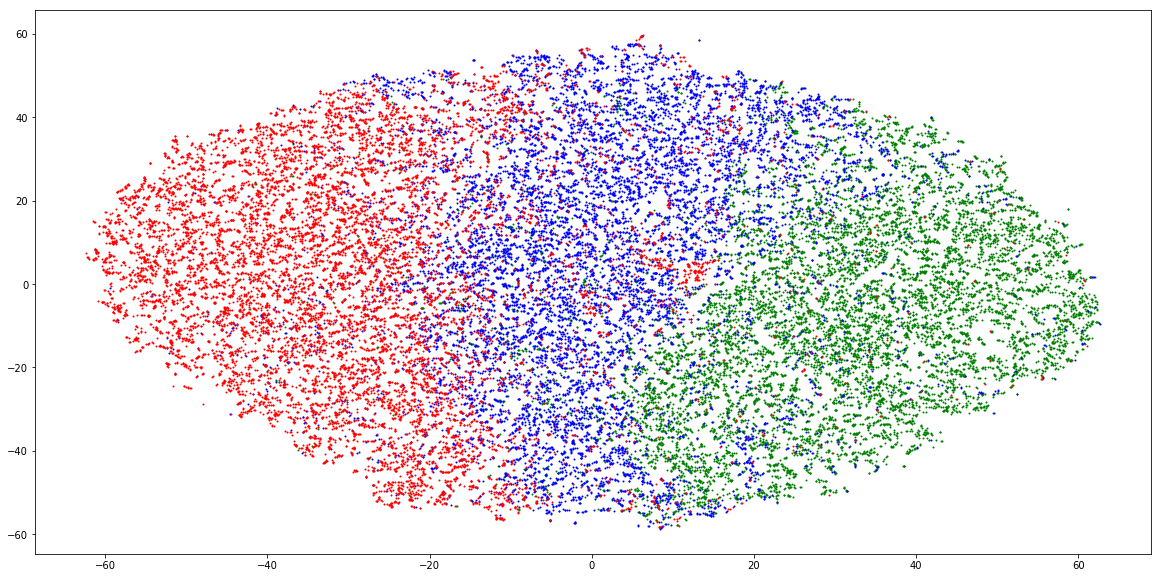

In [98]:
fig1 = plt.figure(figsize=(20,10),facecolor='white')
ax = fig1.add_subplot(1, 1, 1) 
ax.set_facecolor('white')
plt.scatter(X_embedded[0:(len(posemb)-1),0], X_embedded[0:(len(posemb)-1),1], color='g', s=1)
plt.scatter(X_embedded[(len(posemb)):(len(posemb)+len(neutralemb)-1),0], X_embedded[(len(posemb)):(len(posemb)+len(neutralemb)-1),1], color='b', s=1)
plt.scatter(X_embedded[(len(posemb)+len(neutralemb)):(len(posemb)+len(neutralemb)+len(negemb)-1),0], X_embedded[(len(posemb)+len(neutralemb)):(len(posemb)+len(neutralemb)+len(negemb)-1),1], color='r', s=1)

plt.show()

Ahora si! los embeddings no sólo estan claramente diferenciado sino que hasta puede verse un orden, donde los negativos están a la izquierda, los neutrales en el medio y los positivos a al derecha!

Veamos finalmente como clasifica el randomForest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(allembds,tags, test_size=0.2, random_state=0)

In [101]:
tuned_parameters =  {'max_depth': sp_randint(2, 20),"max_features": sp_randint(2, 34),"n_estimators":sp_randint(5, 20)}


clfdt = RandomizedSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='f1_macro',n_jobs=5)
clfdt.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [102]:
randomForest = RandomForestClassifier(max_depth=clfdt.best_params_['max_depth'],max_features=clfdt.best_params_['max_features'],n_estimators=clfdt.best_params_['n_estimators'])
randomforest =  cross_val_score(randomForest, X_train, y_train, cv=5, scoring='f1_macro',n_jobs=5)

In [103]:
print("Random Forest F1_score: %0.2f (+/- %0.2f)" % (randomforest.mean(), randomforest.std() * 2))

Random Forest F1_score: 0.86 (+/- 0.01)
